In [1]:
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, LeakyReLU, BatchNormalization
from tensorflow.keras.utils import plot_model, to_categorical


## Data Loading and Processing

In [7]:
import os

DATA_DIR = ''
if "anuja" in os.environ.get('USER'):
    DATA_DIR = 'data/'

In [8]:
# data loading
data = scipy.io.loadmat(DATA_DIR+'x.mat')  
columns = np.asarray([['Electrode %d - %d/2 Hz'%(i+1, j+1)] for i in range(data['x'].shape[1]) for j in range(data['x'].shape[2])])
data['x'].shape
labels = pd.read_csv(DATA_DIR+"table_withlabels.csv")
foof = pd.read_csv(DATA_DIR+"foof2features.csv")
beh = pd.read_csv(DATA_DIR+"behaviorals.csv")
df = pd.DataFrame(data['x'].reshape((data['x'].shape[0], -1)))
df.columns = columns
df['IDs'] = foof['C1']
df = pd.merge(df, labels[['label', 'IDs']], on='IDs', how='inner')
print(df['label'].value_counts())

Other Neurodevelopmental Disorders    492
ADHD-Inattentive Type                 388
ADHD-Combined Type                    376
Anxiety Disorders                     241
No Diagnosis Given                    203
Depressive Disorders                   85
Name: label, dtype: int64


In [9]:
# add labels
pd.options.mode.chained_assignment = None

df.label[df.label == 'Other Neurodevelopmental Disorders'] = 1
df.label[df.label == 'ADHD-Inattentive Type'] = 2
df.label[df.label == 'ADHD-Combined Type'] = 3
df.label[df.label == 'Anxiety Disorders'] = 4
df.label[df.label == 'No Diagnosis Given'] = 5
df.label[df.label == 'Depressive Disorders'] = 6
df.label = df['label'].astype(int)
labels = ['Other Neurodevelopmental Disorders', 'ADHD-Inattentive Type', 'ADHD-Combined Type', 'Anxiety Disorders', 'No Diagnosis Given', 'Depressive Disorders']

In [12]:
# data splitting

train_df, test_df = train_test_split(df, test_size=0.3, stratify=df['label'])

train_labels, test_labels = train_df['label'], test_df['label']
train_labels_categorical, test_labels_categorical = to_categorical(train_df['label']-1), to_categorical(test_df['label']-1)

train_features = train_df[train_df.columns.difference(['IDs', 'label'])]
test_features = test_df[test_df.columns.difference(['IDs', 'label'])]

## AutoEncoder for Feature Extraction

In [7]:
n_inputs = train_features.shape[1]

visible = Input(shape=(n_inputs,))
e = Dense(n_inputs*2)(visible)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
e = Dense(n_inputs)(e)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
n_bottleneck = round(float(n_inputs) / 2.0)
bottleneck = Dense(n_bottleneck)(e)

d = Dense(n_inputs)(bottleneck)
d = BatchNormalization()(d)
d = LeakyReLU()(d)

d = Dense(n_inputs*2)(d)
d = BatchNormalization()(d)
d = LeakyReLU()(d)

output = Dense(n_inputs, activation='linear')(d)

model = Model(inputs=visible, outputs=output)
model.compile(optimizer='adam', loss='mse')
plot_model(model, 'autoencoder_compress.png', show_shapes=True)

history = model.fit(train_features, train_labels, epochs=50, batch_size=16, verbose=2)
encoder = Model(inputs=visible, outputs=bottleneck)

plot_model(encoder, 'encoder_compress.png', show_shapes=True)
encoder.save('autoencoder.h5')

Epoch 1/50
79/79 - 7s - loss: 5.8767 - 7s/epoch - 85ms/step
Epoch 2/50
79/79 - 5s - loss: 4.2238 - 5s/epoch - 62ms/step
Epoch 3/50
79/79 - 5s - loss: 3.1812 - 5s/epoch - 62ms/step
Epoch 4/50
79/79 - 5s - loss: 3.4555 - 5s/epoch - 62ms/step
Epoch 5/50
79/79 - 5s - loss: 3.1266 - 5s/epoch - 62ms/step
Epoch 6/50
79/79 - 5s - loss: 3.3277 - 5s/epoch - 62ms/step
Epoch 7/50
79/79 - 5s - loss: 3.3593 - 5s/epoch - 62ms/step
Epoch 8/50
79/79 - 5s - loss: 3.0566 - 5s/epoch - 62ms/step
Epoch 9/50
79/79 - 5s - loss: 2.9914 - 5s/epoch - 62ms/step
Epoch 10/50
79/79 - 5s - loss: 2.7312 - 5s/epoch - 62ms/step
Epoch 11/50
79/79 - 5s - loss: 2.8620 - 5s/epoch - 62ms/step
Epoch 12/50
79/79 - 5s - loss: 3.1014 - 5s/epoch - 62ms/step
Epoch 13/50
79/79 - 5s - loss: 2.8700 - 5s/epoch - 62ms/step
Epoch 14/50
79/79 - 5s - loss: 3.0480 - 5s/epoch - 62ms/step
Epoch 15/50
79/79 - 5s - loss: 2.9254 - 5s/epoch - 62ms/step
Epoch 16/50
79/79 - 5s - loss: 2.5803 - 5s/epoch - 62ms/step
Epoch 17/50
79/79 - 5s - loss: 3.

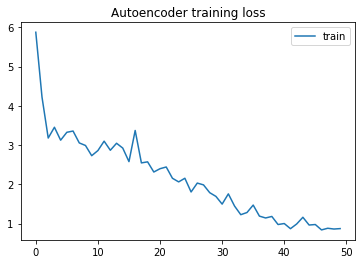

In [8]:
  # plot loss
  plt.plot(history.history['loss'], label='train')
  plt.title('Autoencoder training loss')
  plt.legend()
  plt.show()

In [9]:
# encode the data
encoder= load_model('autoencoder.h5', compile=False)

train_features_encoded = encoder.predict(train_features)
test_features_encoded = encoder.predict(test_features)

## Dealing with imbalance

In [10]:
oversample = SMOTE()
train_features_encoded_oversampled, train_labels_oversampled = oversample.fit_resample(train_features_encoded, train_labels)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

In [11]:
np.save('train_features_encoded_oversampled.npy', train_features_encoded_oversampled)
np.save('train_labels_oversampled.npy', train_labels_oversampled)
np.save('train_features_encoded.npy', train_features_encoded)
np.save('test_features_encoded.npy', test_features_encoded)

In [26]:
# scaling the data

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_features_encoded_oversampled = scaler.fit_transform(train_features_encoded_oversampled)
test_features_encoded = scaler.transform(test_features_encoded)

train_features_encoded_oversampled = np.clip(train_features_encoded_oversampled, -5, 5)
test_features_encoded = np.clip(test_features_encoded, -5, 5)

In [28]:
print(train_features_encoded_oversampled.shape)
print(train_labels_oversampled.shape)
print(test_features_encoded.shape)
print(test_labels.shape)

(2106, 4148)
(2106,)
(536, 4148)
(536,)


## Linear Models

### SVC

In [38]:
from sklearn import svm

clf = svm.SVC(kernel='linear', verbose=True)
clf.fit(train_features_encoded_oversampled, train_labels_oversampled)

predicted_labels_svc = clf.predict(test_features_encoded)

[LibSVM]

Accuracy: 0.19776119402985073
Precision: 0.19776119402985073
Recall: 0.19776119402985073
F1 score: 0.19776119402985073


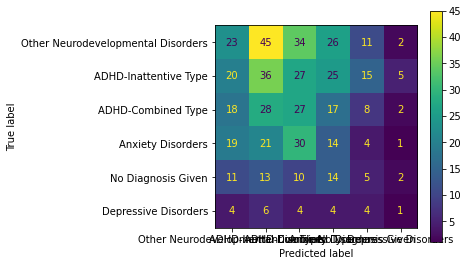

In [39]:
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def evaluate(y_test, y_pred, show_cm=True):
    
    print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
    print("Precision:", metrics.precision_score(y_test, y_pred, average='micro'))
    print("Recall:", metrics.recall_score(y_test, y_pred, average='micro'))
#     print("ROC AUC:", metrics.roc_auc_score(y_test, y_pred, multi_class='ovo',))
    print("F1 score:", metrics.f1_score(y_test, y_pred, average='micro'))
#     print("Brier Score:", metrics.brier_score_loss(y_test, y_pred)) # only for binary classification

    if show_cm:
        cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
        disp.plot()
        plt.tight_layout()
        plt.show()

evaluate(test_labels, predicted_labels_svc)

### OneVsRestClassifier
The strategy consists in fitting one classifier per class. For each classifier, the class is fitted against all the other classes.

In [29]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC

clf = OneVsRestClassifier(LinearSVC(random_state=0, max_iter=2000, verbose=True))

clf.fit(train_features_encoded_oversampled, train_labels_oversampled)
predicted_labels_ovr = clf.predict(test_features_encoded)

[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Accuracy: 0.22014925373134328
Precision: 0.22014925373134328
Recall: 0.22014925373134328
F1 score: 0.22014925373134328


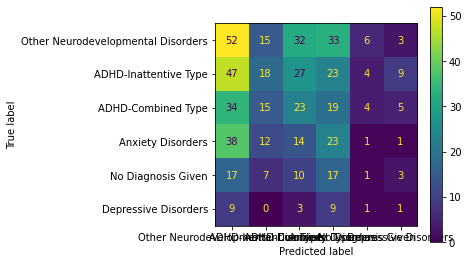

In [30]:
evaluate(test_labels, predicted_labels_ovr)

### OneVsOneClassifier
OneVsOneClassifier constructs one classifier per pair of classes. At prediction time, the class which received the most votes is selected. In the event of a tie (among two classes with an equal number of votes), it selects the class with the highest aggregate classification confidence by summing over the pair-wise classification confidence levels computed by the underlying binary classifiers.



In [32]:
from sklearn.multiclass import OneVsOneClassifier

clf = OneVsOneClassifier(LinearSVC(random_state=0, verbose=True))

clf.fit(train_features_encoded_oversampled, train_labels_oversampled)
predicted_labels_ovo = clf.predict(test_features_encoded)

[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear][LibLinear][LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Accuracy: 0.22014925373134328
Precision: 0.22014925373134328
Recall: 0.22014925373134328
F1 score: 0.22014925373134328


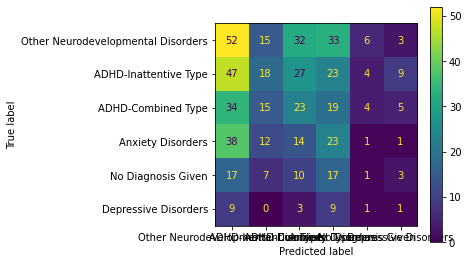

In [33]:
evaluate(test_labels, predicted_labels_ovr)

### Random Forest

In [34]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=5, random_state=0, verbose=True)
clf.fit(train_features_encoded_oversampled, train_labels_oversampled)
predicted_labels_rf = clf.predict(test_features_encoded)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    4.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy: 0.21082089552238806
Precision: 0.21082089552238806
Recall: 0.21082089552238806
F1 score: 0.21082089552238809


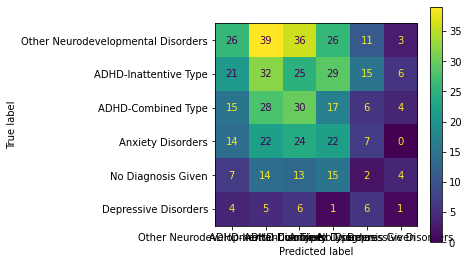

In [35]:
evaluate(test_labels, predicted_labels_rf)

### MLP


In [36]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(random_state=1, max_iter=300, verbose=True)
clf.fit(train_features_encoded_oversampled, train_labels_oversampled)
predicted_labels_mlp = clf.predict(test_features_encoded)

Iteration 1, loss = 2.16573863
Iteration 2, loss = 1.44527067
Iteration 3, loss = 1.31074696
Iteration 4, loss = 1.39675579
Iteration 5, loss = 1.27151219
Iteration 6, loss = 1.10955808
Iteration 7, loss = 1.05873712
Iteration 8, loss = 1.12501524
Iteration 9, loss = 1.04552107
Iteration 10, loss = 1.09717672
Iteration 11, loss = 1.04028231
Iteration 12, loss = 0.96797759
Iteration 13, loss = 0.97454340
Iteration 14, loss = 0.88998478
Iteration 15, loss = 0.91313369
Iteration 16, loss = 0.92382431
Iteration 17, loss = 0.91192924
Iteration 18, loss = 0.94992233
Iteration 19, loss = 0.86641412
Iteration 20, loss = 0.93255636
Iteration 21, loss = 0.87158845
Iteration 22, loss = 0.78465300
Iteration 23, loss = 0.82852789
Iteration 24, loss = 0.85830082
Iteration 25, loss = 0.76815563
Iteration 26, loss = 0.81390572
Iteration 27, loss = 0.82477855
Iteration 28, loss = 0.79732599
Iteration 29, loss = 0.80633452
Iteration 30, loss = 0.76057964
Iteration 31, loss = 0.78792525
Iteration 32, los

Accuracy: 0.22574626865671643
Precision: 0.22574626865671643
Recall: 0.22574626865671643
F1 score: 0.22574626865671643


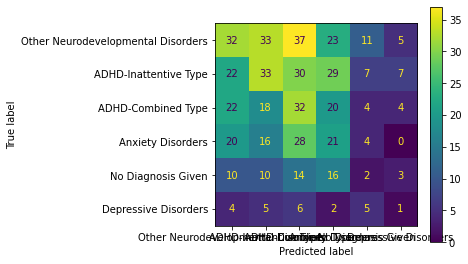

In [37]:
evaluate(test_labels, predicted_labels_mlp)